# Plotting Few-Shot Model Evaluation Results

Assembling plots from summary files.

In [1]:
import os
import sys
import pandas as pd
import ydata_profiling as pp

# Setting up local details:
# This should be the location of the checkout of the FS-Mol repository:
FS_MOL_CHECKOUT_PATH = os.path.join(os.environ['HOME'], "Ersilia-FS", "fs_mol")
# FS_MOL_DATASET_PATH = os.path.join(os.environ['HOME'], "code", "ersilia", "ersilia-fsmol", "datasets", "fs-mol-data")
FS_MOL_DATASET_PATH = os.path.join(os.environ['HOME'], "Ersilia-FS", "dataset")

os.chdir(FS_MOL_CHECKOUT_PATH)
sys.path.insert(0, FS_MOL_CHECKOUT_PATH)

from fs_mol.plotting.utils import (
    highlight_max_all, 
    plot_all_assays, 
    load_data,
    expand_values,
    plot_task_performances_by_id,
    box_plot,
    plot_by_size,
    get_aggregates_across_sizes
)

## Making summary files

Summary files are obtained by running `fs_mol/plotting/collect_eval_runs.py` on the outputs of evaluation runs. If an evaluation output directory is "evaluation_output_directory" then summary files are created with: 

In [2]:
dir_list  = ['FSMol_Eval_ProtoNet_2024-04-30', 'FSMol_Eval_Multitask_2024-04-30', 'FSMol_Eval_randomForest_2024-04-30']
name_list = ['ProtoNet', 'Multitask', 'randomForest']

In [3]:
for model_name, evaluation_output_directory in zip(name_list, ['outputs/test/' + d for d in dir_list]):
    ! python ~/Ersilia-FS/fs_mol/plotting/collect_eval_runs.py {model_name} {evaluation_output_directory}

processing outputs/test/FSMol_Eval_ProtoNet_2024-04-30/CHEMBL1033992_eval_results.csv
/home/gridsan/ppaschalidis/Ersilia-FS/fs_mol/plotting/utils.py:210: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_dfs[val] = pd.concat(
Summarised results for test on assay CHEMBL1033992
processing outputs/test/FSMol_Eval_ProtoNet_2024-04-30/CHEMBL1107216_eval_results.csv
Summarised results for test on assay CHEMBL1107216
processing outputs/test/FSMol_Eval_ProtoNet_2024-04-30/CHEMBL1614414_eval_results.csv
Summarised results for test on assay CHEMBL1614414
processing outputs/test/FSMol_Eval_ProtoNet_2024-04-30/CHEMBL1931089_eval_results.csv
/home/gridsan/ppaschalidis/Ersilia-FS/fs_mol/plotting/utils.py:210: FutureWarning: The behavior of DataFrame 

The option `--plot` results in a plot across support set sizes for each few-shot testing task. Final summarized results will be found in "evaluation_output_directory/summary/{model_name}_summary.csv"

## Loading the collated evaluation data

Create a dictionary of all model summary .csvs to be compared. The csvs are the final summaries from `collect_eval_runs.py`

In [4]:
# Configure this to contain all the models that you want to look at.
# Dict keys are human readable names, values are the path to the summary produced by collect_eval_runs.py
# results_path = os.path.join(FS_MOL_CHECKOUT_PATH, "/ersilia_summaries/")
results_path = "~/Ersilia-FS/fs_mol/outputs/test"

# a dictionary summarising all models to be compared. Add new paths here as desired.
model_summaries = {
    "PN": os.path.join(results_path, f"{dir_list[0]}/summary/{name_list[0]}_summary.csv"),
    # "GNN-MAML": os.path.join(results_path, "MAML-Support16_summary.csv"),
    "GNN-MT": os.path.join(results_path, f"{dir_list[1]}/summary/{name_list[1]}_summary.csv"),
    "RF": os.path.join(results_path, f"{dir_list[2]}/summary/{name_list[2]}_summary.csv"),
    # "MAT": os.path.join(results_path, "MAT_summary.csv"),
    # "GNN-ST": os.path.join(results_path, "GNN-ST_summary.csv"),
#     "kNN": os.path.join(results_path, "kNN_summary.csv"),
}
# Generated plots will be stored here, if you want to keep them. None disables saving.
plot_output_dir = os.path.join(results_path, "plots")
all_tasks_output_dir = os.path.join(results_path, "plots/all_tasks")
os.makedirs(plot_output_dir, exist_ok=True)
os.makedirs(all_tasks_output_dir, exist_ok=True)

In [5]:
data = load_data(model_summaries)

Loading data for PN from ~/Ersilia-FS/fs_mol/outputs/test/FSMol_Eval_ProtoNet_2024-04-30/summary/ProtoNet_summary.csv.
Loading data for GNN-MT from ~/Ersilia-FS/fs_mol/outputs/test/FSMol_Eval_Multitask_2024-04-30/summary/Multitask_summary.csv.
Loading data for RF from ~/Ersilia-FS/fs_mol/outputs/test/FSMol_Eval_randomForest_2024-04-30/summary/randomForest_summary.csv.


## Highlight the best result for each task

In [6]:
styled_df = data.style.apply(lambda row: highlight_max_all(row), axis=1)
# To save for exporting purposes, uncomment this (requires `pip install xlsxwriter`)
styled_df.to_excel(os.path.join(plot_output_dir, f"highlighted_comparison.xlsx"), engine='xlsxwriter')

styled_df

,TASK_ID,fraction_positive_train,fraction_positive_test,16_train (PN),16_train (GNN-MT),16_train (RF)
0,1033992,0.822917,0.857143,0.992+/-0.01,0.978+/-0.028,0.99+/-0.013
1,1107216,0.379167,0.346154,0.437+/-0.127,0.499+/-0.147,0.426+/-0.081
2,1614414,0.177083,0.210412,0.235+/-0.023,0.217+/-0.009,0.212+/-0.009
3,1960329,0.822917,0.833333,0.884+/-0.041,0.855+/-0.045,0.824+/-0.065
4,2021151,0.500000,0.500000,0.825+/-0.198,0.867+/-0.168,0.892+/-0.152
5,2037882,0.500000,0.500000,0.9+/-0.211,0.8+/-0.258,0.7+/-0.258
6,2061397,0.500000,0.444444,0.476+/-0.083,0.471+/-0.074,0.579+/-0.1
7,2320857,0.895833,0.904762,0.87+/-0.04,0.903+/-0.038,0.89+/-0.048
8,2388705,0.500000,0.500000,0.677+/-0.105,0.672+/-0.068,0.631+/-0.069
9,2439555,0.500000,0.470588,0.619+/-0.078,0.555+/-0.113,0.568+/-0.114


In [7]:
# expand out from val +/- error format, and calculate delta AUPRC
data = expand_values(data, model_summaries)

## Performance Overview over all Tasks

This compares with the trivial baseline of using a weighted coinflip according to the class imbalance in the training data.

/home/gridsan/ppaschalidis/Ersilia-FS/fs_mol/plotting/utils.py:679: UserWarning: FixedFormatter should only be used together with FixedLocator
  assay_id_to_improv_ax.set_xticklabels(merged_df["TASK_ID"][0:-1:4])


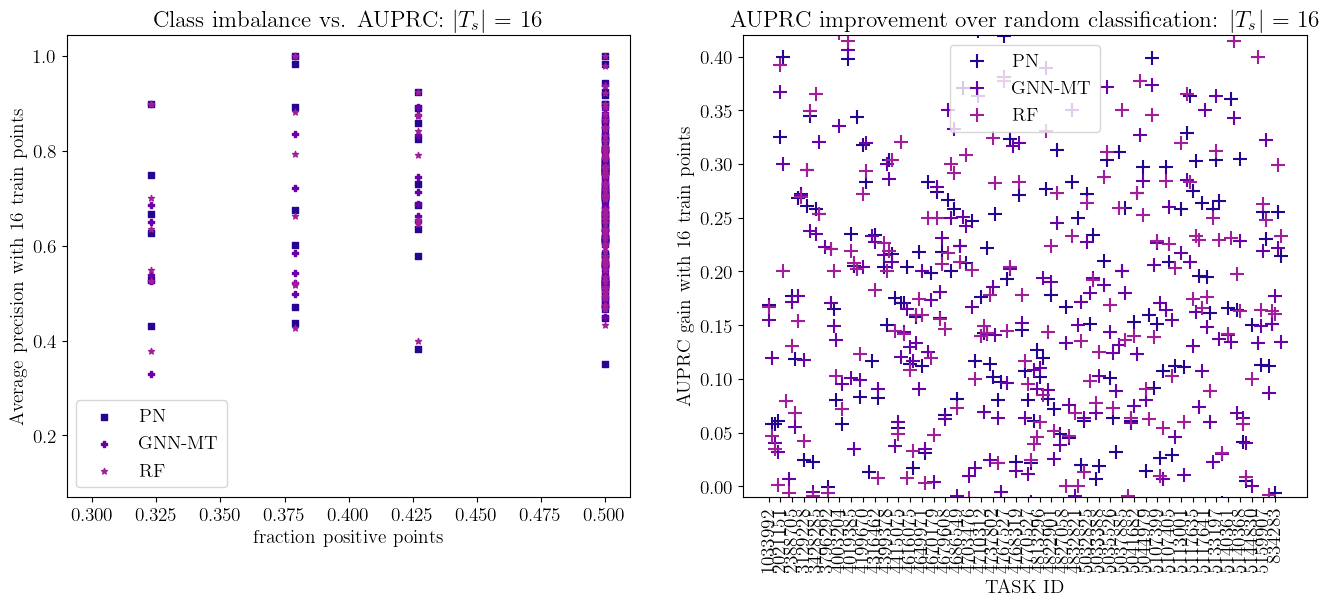

In [8]:
# This uses Latex to render plots, and requires the type1ec and type1cm packages.
# It also required the dvipng utility.
# On Debian/Ubuntu-based systems, this can be installed using `apt install cm-super texlive-latex-extra dvipng`

plot_task_performances_by_id(data, model_summaries, support_set_size = 16, plot_output_dir = plot_output_dir)

### Incorporate target information

Our test tasks have associated target organism information available. We can merge this data to allow plotting with specific EC number classes highlighted.

In [9]:
target_path = os.path.join(FS_MOL_DATASET_PATH, "test_set_targets.csv")
ecs = pd.read_csv(target_path)
ecs["target_id"] = ecs["target_id"].astype(int).astype(str)
ecs["chembl_id"] = ecs["chembl_id"].astype(str)
ecs["TASK_ID"] = ecs.apply(lambda row: row["chembl_id"][6:], axis = 1)

data = ecs.merge(data, on="TASK_ID")

In [10]:
# the highlight class is the EC class that will be highlighted in the resulting plot. 
# You may wish to use this for comparison across different EC classes.

# plot_task_performances_by_id(data, model_summaries, support_set_size = 16, highlight_class = 'fungus')

## Plot for each task, comparing different models

This makes an individual comparison plot over models for each few-shot testing task, across all support set sizes available. 

**Warning** Not to use lightly, it will take a few minutes to complete

In [11]:
# plot_all_assays(data, model_summaries.keys(), results_dir = all_tasks_output_dir)

# Summarise the overall performance in box plots

This reproduces the model comparison box plots in the manuscript.

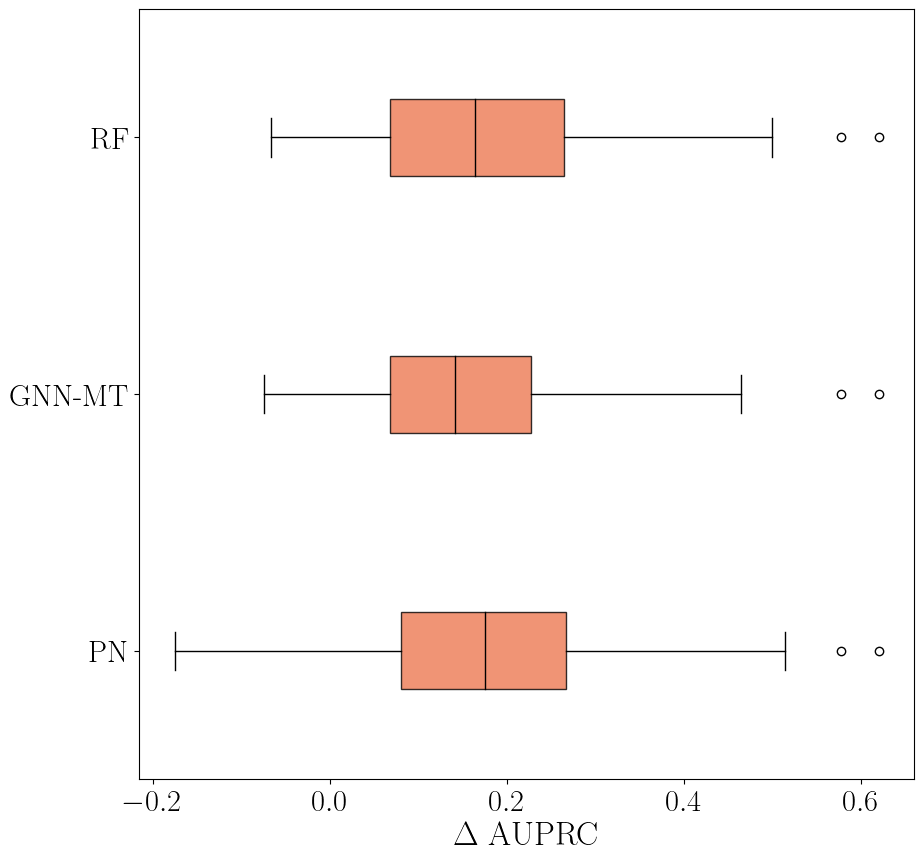

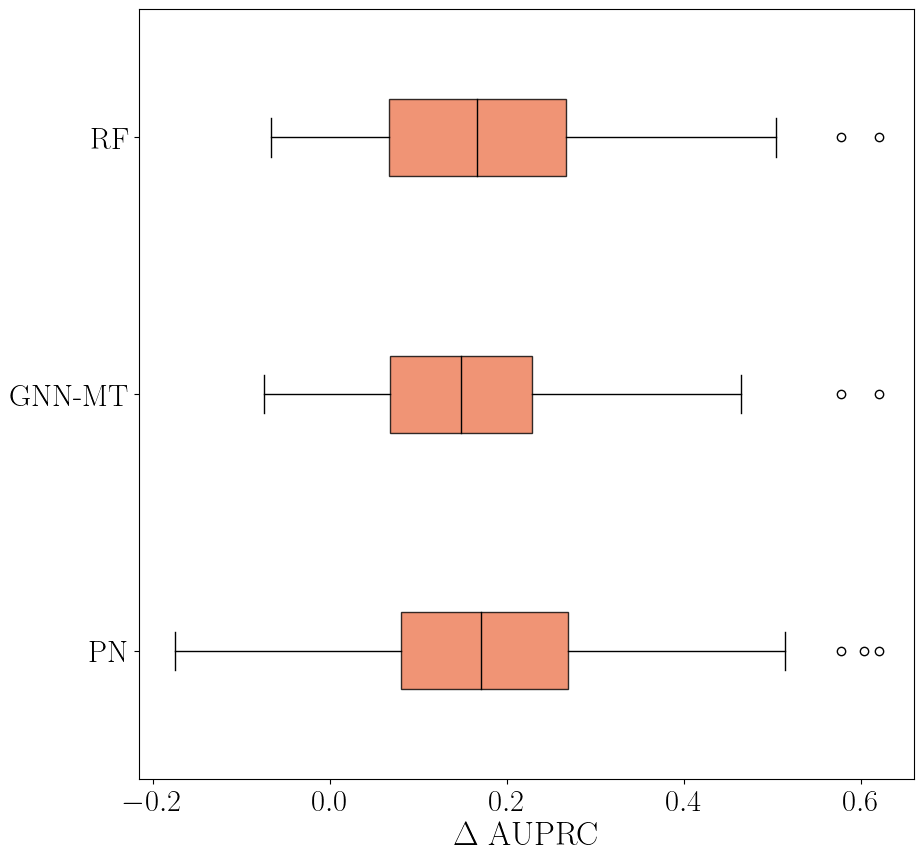

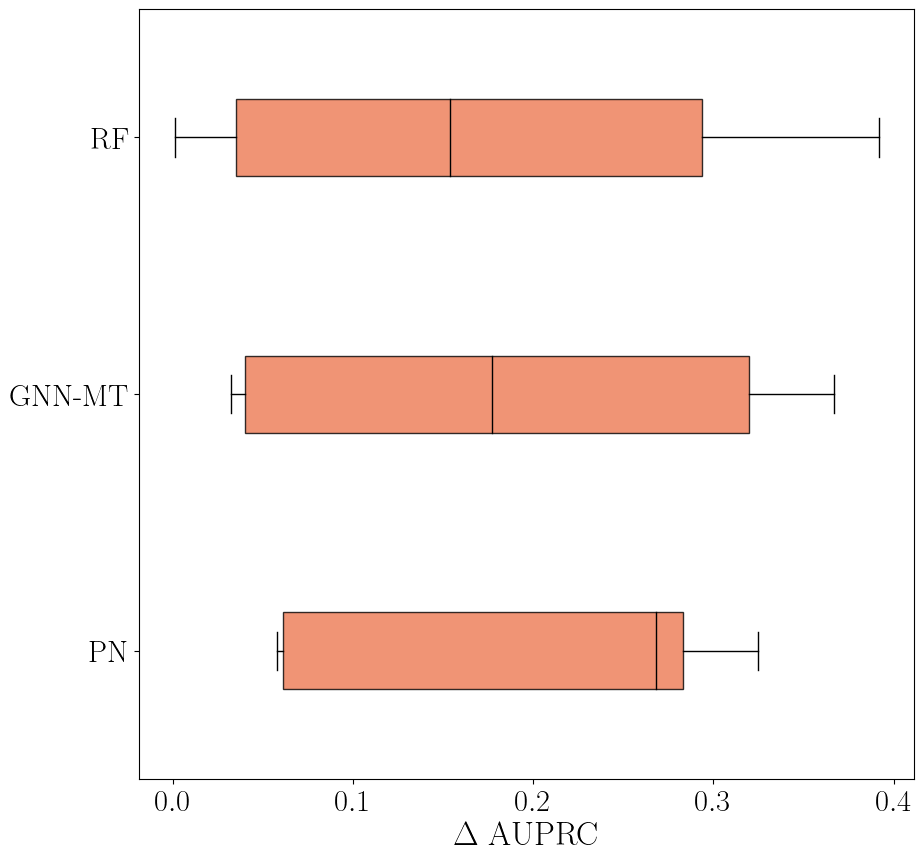

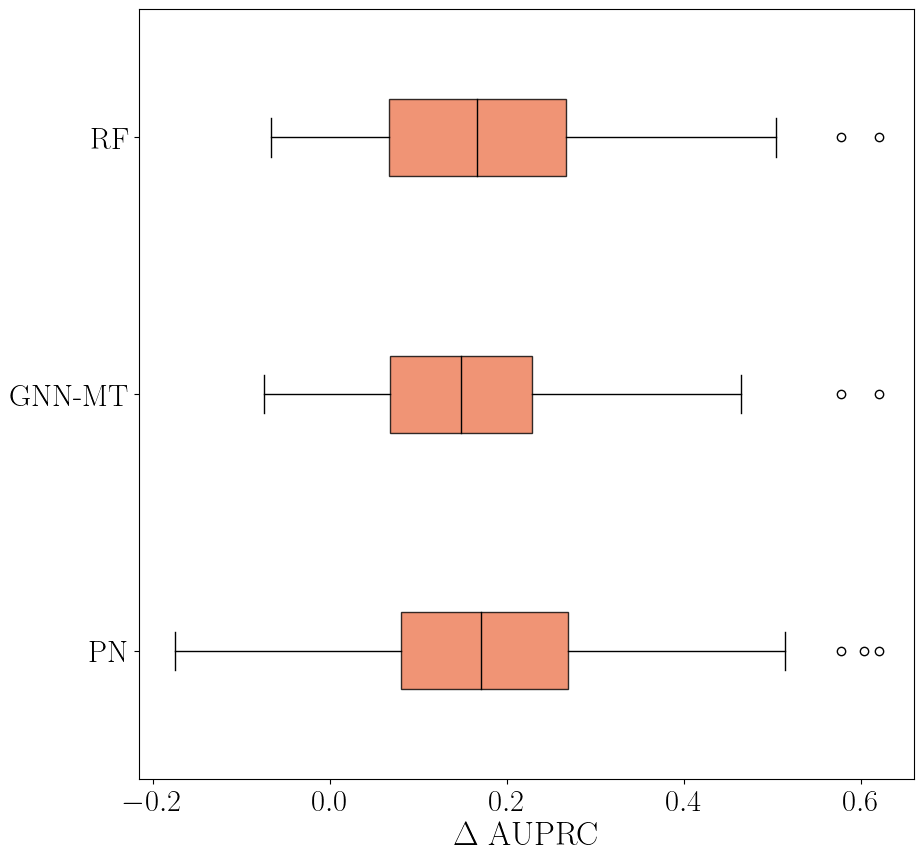

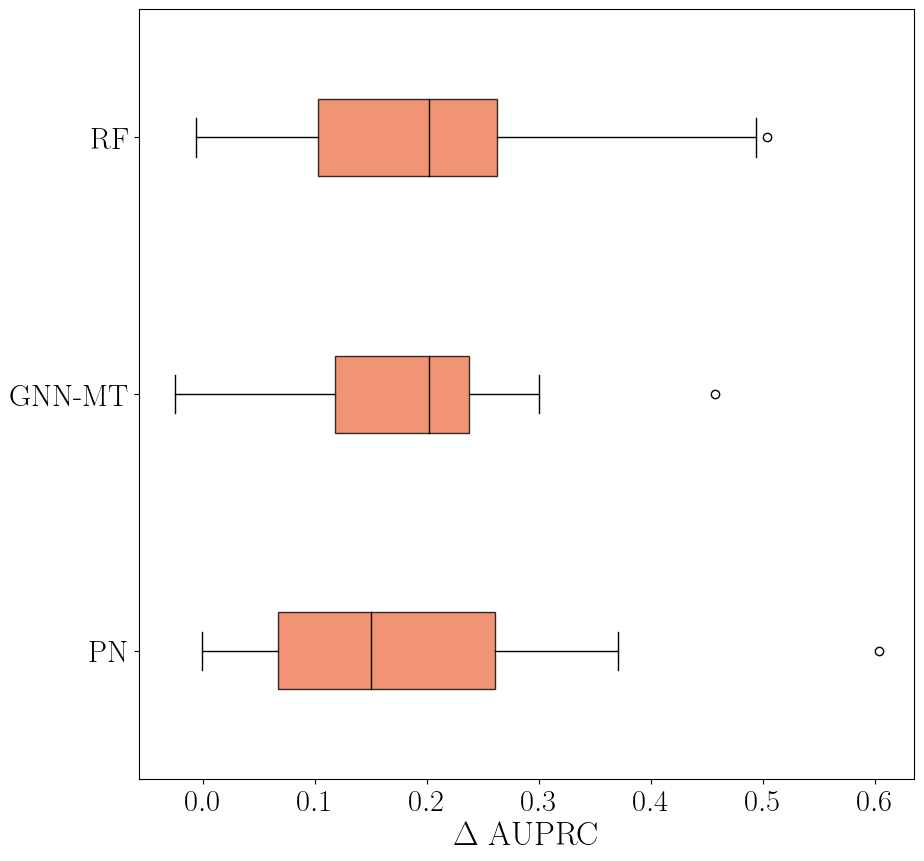

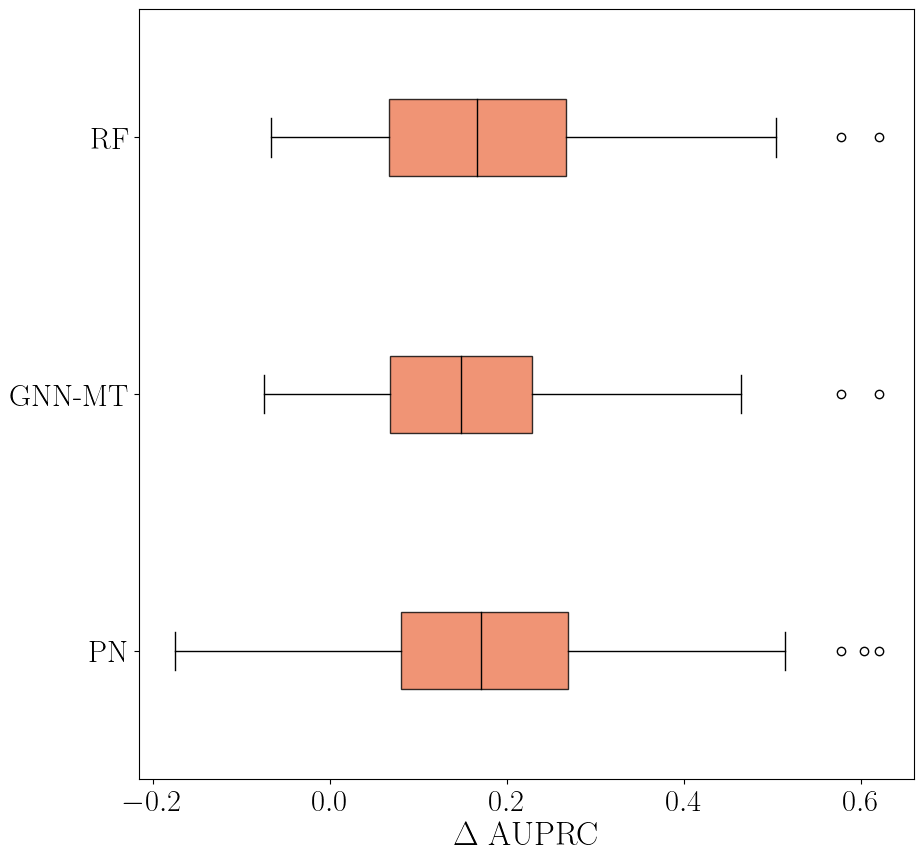

In [12]:
for highlight_class in ['Viruses', 'Fungi', 'Bacteria']:
    box_plot(data, model_summaries, support_set_size = 16, plot_output_dir=plot_output_dir, highlight_class = highlight_class)

## Aggregate as a function of the number of training points, across all categories

Here the results are aggregated according to EC class, and across all classes. This is used to plot the variation of performance with support set size, comparing all models in the model_summaries dictionary. 

In [13]:
aggregate_df = get_aggregates_across_sizes(data, model_summaries)

In [14]:
# show results of Table 2 for support set size 16
cols = [x for x  in aggregate_df.columns if x.startswith("16")]
aggregate_df[cols]

,16_train (PN),16_train (GNN-MT),16_train (RF),16_train (PN) std,16_train (GNN-MT) std,16_train (RF) std
Target type,,,,,,
Viruses,0.182389,0.159463,0.176047,0.011849,0.010515,0.011519
Fungi,0.199000,0.187200,0.175200,0.057713,0.069209,0.074679
Bacteria,0.180516,0.181135,0.196421,0.033080,0.024639,0.031014
all,0.182639,0.162856,0.178468,0.010909,0.009591,0.010643


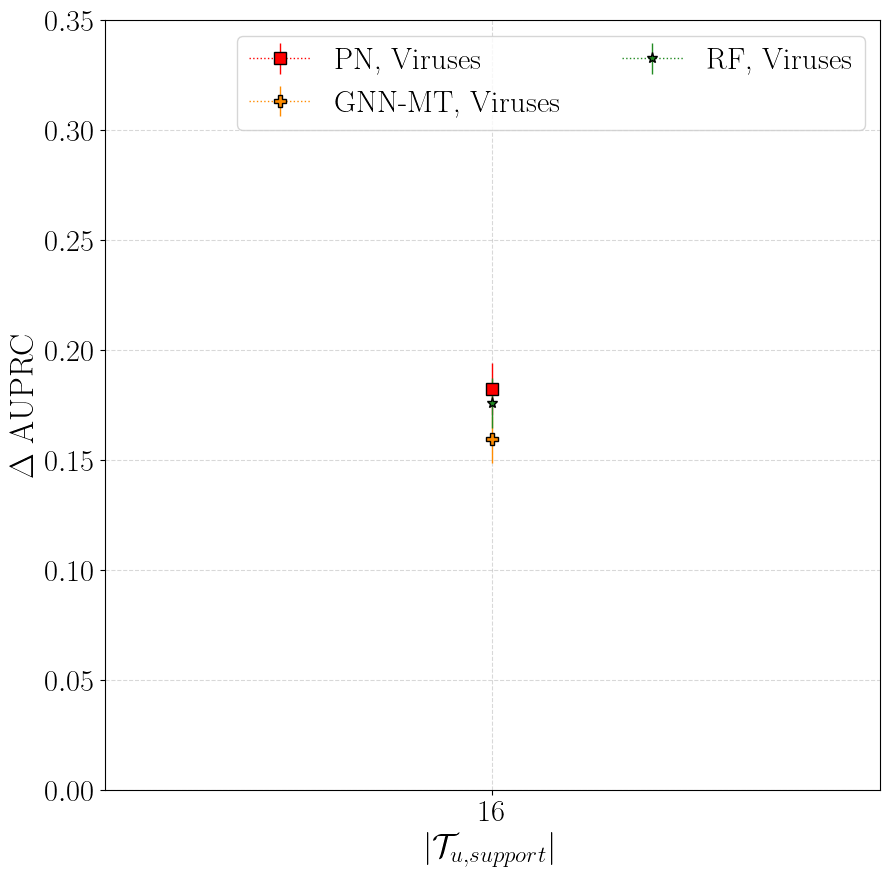

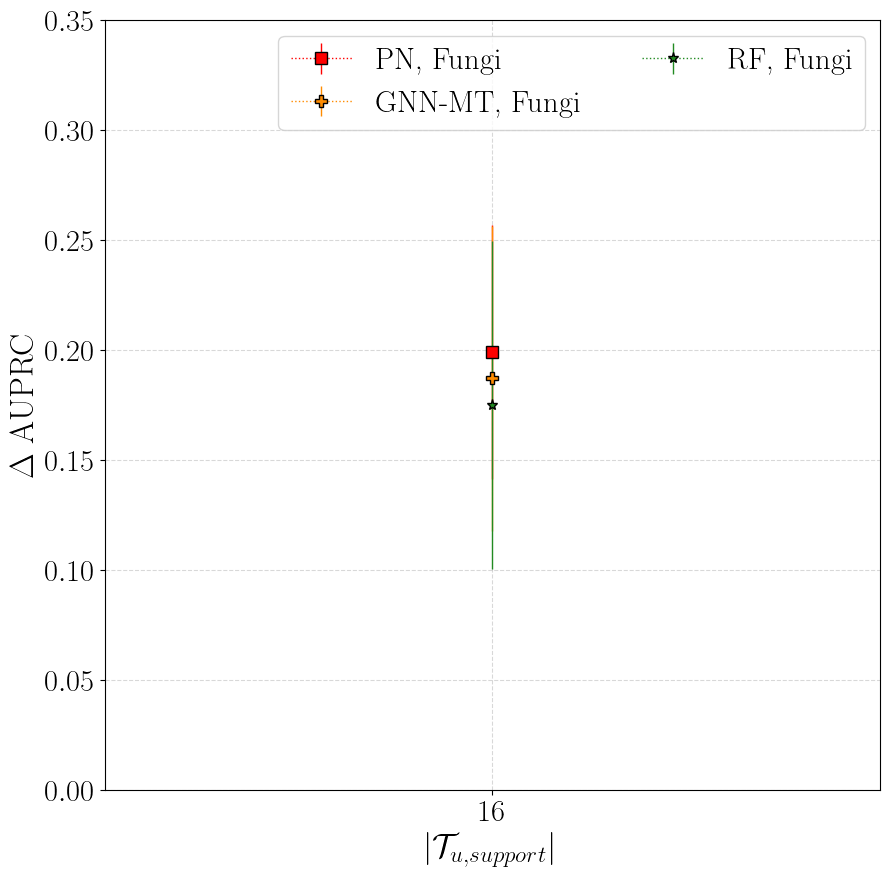

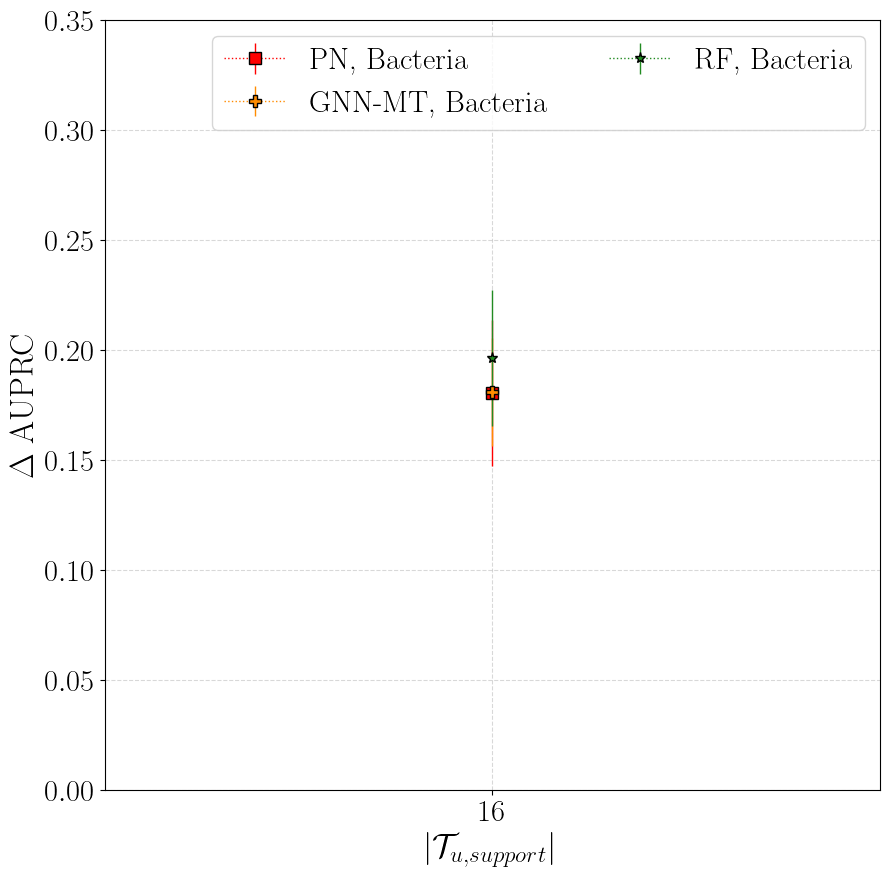

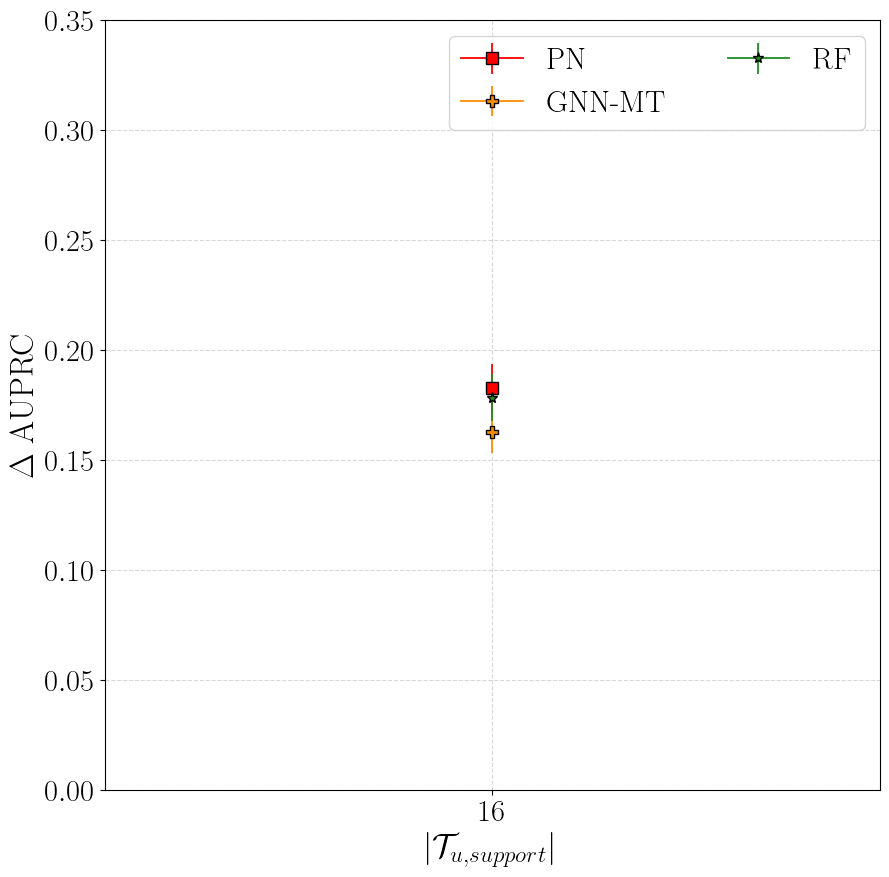

In [15]:
# this function has the option to plot all classes separately.
for highlight_class in ['Viruses', 'Fungi', 'Bacteria', 'all']:
    plot_by_size(aggregate_df, model_summaries, plot_output_dir = plot_output_dir, highlight_class = highlight_class)

# Ranking

Here we use [autorank](https://pypi.org/project/autorank/) for an appropriate comparison between all methods when evaluated on multiple tasks.


In [16]:
import matplotlib as plt
plt.rc('text', usetex=False)
from autorank import autorank

# select correct data to rank with autorank
for size in [16]:    
    # Do it for specific target types
    for highlight_class in ['Viruses', 'Bacteria', 'Fungi']:
        print("--------------------------------------------------")
        print(f"Highlight Class: {highlight_class}") 

        data_class = data.loc[data['organism_taxonomy_l1'] == highlight_class]
        df = data_class[[x for x in list(data.columns) if x.startswith(f"{size}") and "val" in x and "delta-auprc" in x]]
        result = autorank(df, verbose=False)
        print(result.rankdf["meanrank"])
        
    # Do it over all target types
    print("--------------------------------------------------")
    print("All Classes")
    df = data[[x for x in list(data.columns) if x.startswith(f"{size}") and "val" in x and "delta-auprc" in x]]
    result = autorank(df, verbose=False)
    print(result.rankdf["meanrank"])

--------------------------------------------------
Highlight Class: Viruses
16_train (GNN-MT) val delta-auprc    2.184564
16_train (RF) val delta-auprc        1.959732
16_train (PN) val delta-auprc        1.855705
Name: meanrank, dtype: float64
--------------------------------------------------
Highlight Class: Bacteria
16_train (PN) val delta-auprc        2.190476
16_train (GNN-MT) val delta-auprc    2.047619
16_train (RF) val delta-auprc        1.761905
Name: meanrank, dtype: float64
--------------------------------------------------
Highlight Class: Fungi
16_train (RF) val delta-auprc        2.4
16_train (PN) val delta-auprc        1.8
16_train (GNN-MT) val delta-auprc    1.8
Name: meanrank, dtype: float64
--------------------------------------------------
All Classes
16_train (GNN-MT) val delta-auprc    2.157143
16_train (RF) val delta-auprc        1.948571
16_train (PN) val delta-auprc        1.894286
Name: meanrank, dtype: float64
